##Данные и библиотеки


In [0]:
!pip install pandas scikit-learn matplotlib

In [0]:
import tensorflow as tf

In [0]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')


In [4]:
!unzip '/content/drive/My Drive/data.zip' 

Archive:  /content/drive/My Drive/data.zip
  inflating: avito_data.csv          
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [0]:
quora = pd.read_csv('quora.csv')

In [0]:
quora

## Предобработка

In [0]:
def preprocess(text): 
    tokens = list(text)
    return tokens

In [0]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [0]:
#vocab

In [0]:
len(vocab)

2047

In [0]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 3:
        filtered_vocab.add(word)

In [11]:
len(filtered_vocab)

642

In [0]:
# индексируем символы
sym2id = {'UNK':1, 'PAD':0}

for sym in filtered_vocab:
    sym2id[sym] = len(sym2id)

In [0]:
id2sym = {i:sym for sym, i in sym2id.items()}

In [0]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [sym2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [0]:
MEAN_LEN = np.median([len(x) for x in X])

In [0]:
MAX_LEN, MEAN_LEN

(1017, 60.0)

In [0]:
 MAX_LEN = 70

In [0]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [18]:
X.shape

(1306122, 70)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

##Метрики

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##Сеточка

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=60)(inputs)

conv = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(embeddings)

convs1 = []
for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(conv)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs1.append(conv2)

concat1 = tf.keras.layers.concatenate(convs1, axis=2)

drop1 = tf.keras.layers.Dropout(0.2)(concat1)

convs2 = []
for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs2.append(conv2)

concat2 = tf.keras.layers.concatenate(convs2, axis=2)  

conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(concat2)
pool = tf.keras.layers.MaxPool1D()(conv3)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pool)#pool или conv3 (если второе, то поменять местами)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [43]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 70, 60)       38640       input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_136 (Conv1D)             (None, 66, 32)       9632        embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_137 (Conv1D)             (None, 66, 32)       2080        conv1d_136[0][0]                 
____________________________________________________________________________________________

In [41]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 2364s 4s/step - loss: 0.4984 - f1: 1.7545e-04 - val_loss: 0.2117 - val_f1: 0.0000e+00
Epoch 2/5
621/621 [==============================] - 2360s 4s/step - loss: 0.1911 - f1: 0.1287 - val_loss: 0.1872 - val_f1: 0.0847
Epoch 3/5
621/621 [==============================] - 2340s 4s/step - loss: 0.1766 - f1: 0.2665 - val_loss: 0.1697 - val_f1: 0.2914
Epoch 4/5
621/621 [==============================] - 2343s 4s/step - loss: 0.1701 - f1: 0.2991 - val_loss: 0.1663 - val_f1: 0.3205
Epoch 5/5
621/621 [==============================] - 2349s 4s/step - loss: 0.1662 - f1: 0.3177 - val_loss: 0.1767 - val_f1: 0.1940


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


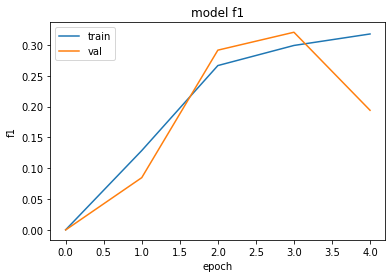

In [42]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Переобучил
На четвёртой эпохе f1 был побольше